## Erdos-Renyi SC Final Version Rates

In [1]:
import numpy as np
import matplotlib.pylab as plt
import random
from scipy.special import comb

import sys
sys.path.append('../src/')
from higher_order_structures import ErdosRenyiSC
from simulate_gillespie import *
from estimate_total_rates import *


## Setup

In [3]:
test_name = "random_ER"

N = 1000
d1, d2 = (20, 6)
g = ErdosRenyiSC(N, d1, d2)

I0 = 1
nsims = 500
run_gillespie_simulations = True
time_max = 50

# set beta1, beta2 such that k^* = .75 N
mu    = 1             # recovery rate

# lambda_1 \in [0,3]
# lambda_2 \in [0,10]
lambda1 = 1
lambda2 = 4

beta1 = lambda1 * mu / d1 # pairwise infection rate
beta2 = lambda2 * mu / d2 # hyperedge contagion rate

# g.summary()

print(f"{test_name}: \n")
print(f"\tH = {g.name}, N = {N}, (d1, d2) = {(d1, d2)}, I0 = {I0}, time_max = {time_max},")
g.print()

print(f"\tbeta1 * N = {beta1 * N:.2f}, beta2 * N^2 = {beta2 * (N**2):.2f}, mu = {mu},")
print(f"\twith estimation based on {nsims} Gillespie simulation runs\n")

random_ER: 

	H = Erdos-Renyi-SC, N = 1000, (d1, d2) = (20, 6), I0 = 1, time_max = 50,
	Erdos-Renyi-SC on 1000 nodes with 11849 edges.

	beta1 * N = 50.00, beta2 * N^2 = 666666.67, mu = 1,
	with estimation based on 500 Gillespie simulation runs



## Run Gillespie

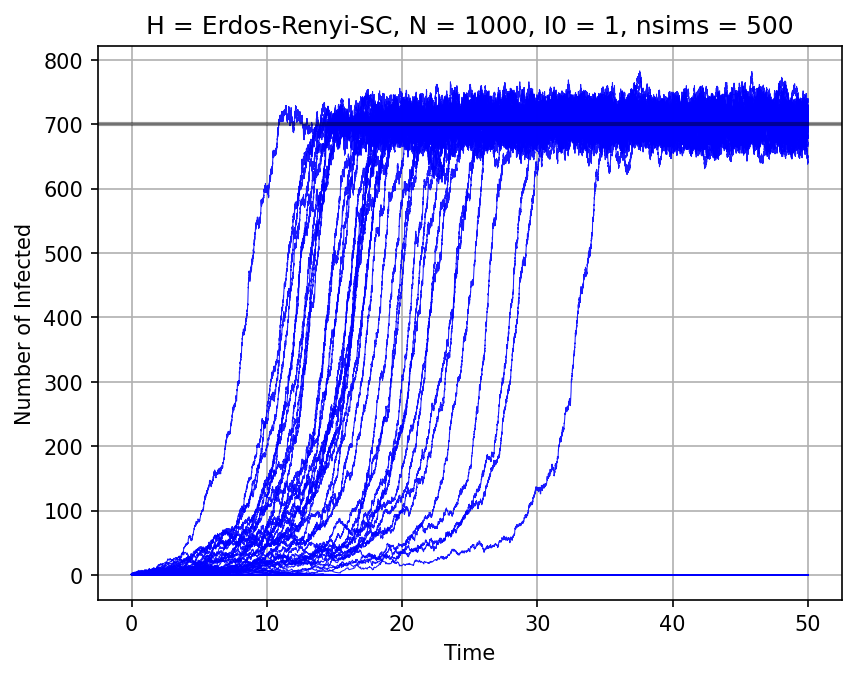

In [10]:
## --- Run Gillespie ---
run_gillespie_simulations = False

I0_gillespie = I0 # TODO: go over the range when necessary
nodes = list(g.nodes.keys())
initial_infections = random.sample(nodes, I0)

if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        X_t = gillespie_sim(g, beta1, beta2, mu, initial_infections, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed(f'../results/gillespie-sims_{test_name}.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load(f'../results/gillespie-sims_{test_name}.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

plt.axhline(y=int(0.7 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, I0 = {I0}, nsims = {nsims}")
plt.savefig(f"../figures/estimation/{test_name}/gillespie-sims.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

## Burn-in / alignment approach

### Idea:
Once an outbreak takes hold (reaches certain number of infected `k_threshold`), the subsequent dynamics (growth phase to quasi-stationary state) should look similar accross different runs, just shifted in time due to initial very variable initial phase.

### Burn-in / alignment approach:

1. Choose `k_threshold = 0.1 * N` (or a fixed number like 50 or 100)

2. For each simulation run `i` that reaches `k_threshold`, find time `t_i` when it first crosses `k_threshold`

3. Time-shift each such run `i`: `t = t - t_i`, to align the trajectory to the point where outbreak reached `k_threshold`

4. Then average all aligned trajectories, to get an average trajectory

### Similarity to complete graph:
Once critical mass of infection is present, average rate of new infections in well connected E-R graph should behave more like on well-mixed complete graph, influenced by overall density, such that expected $a_k, b_k$ rates are $a_k, b_k$ rates for complete scaled by $p_1, p_2$.

In [5]:
def align_trajectories(X_sims, k_threshold, new_time_max):
    X_sims_aligned = []

    for i, X_t in enumerate(X_sims):
        times_orig = X_t[0, :].astype(float)
        infected_orig = X_t[2, :].astype(int)
        above_threshold_indices = np.where(infected_orig >= k_threshold)[0]
        if len(above_threshold_indices) > 0:
            # outbreak reached the threshold
            start_index = above_threshold_indices[0]
            start_time = times_orig[start_index]

            times_shifted = times_orig[start_index:] - start_time
            end_indices = np.where(times_shifted > new_time_max)[0]

            if len(end_indices) > 0:
                end_index = start_index + end_indices[0]
            else:
                # skip it
                print("Run ended before start_time + new_time_max")
            X_t_aligned = X_t[:, start_index:end_index].copy()

            # update times in X_t to times_shifted
            X_t_aligned[0, :] = times_shifted[:len(X_t_aligned[0,:])]
            X_sims_aligned.append(X_t_aligned)
    
    print(f"Aligned {len(X_sims_aligned)}/{len(X_sims)} trajectories.")
    return X_sims_aligned

In [6]:
k_threshold = 100
new_time_max = 10.0

X_sims_aligned = align_trajectories(X_sims, k_threshold, new_time_max)

Aligned 41/500 trajectories.


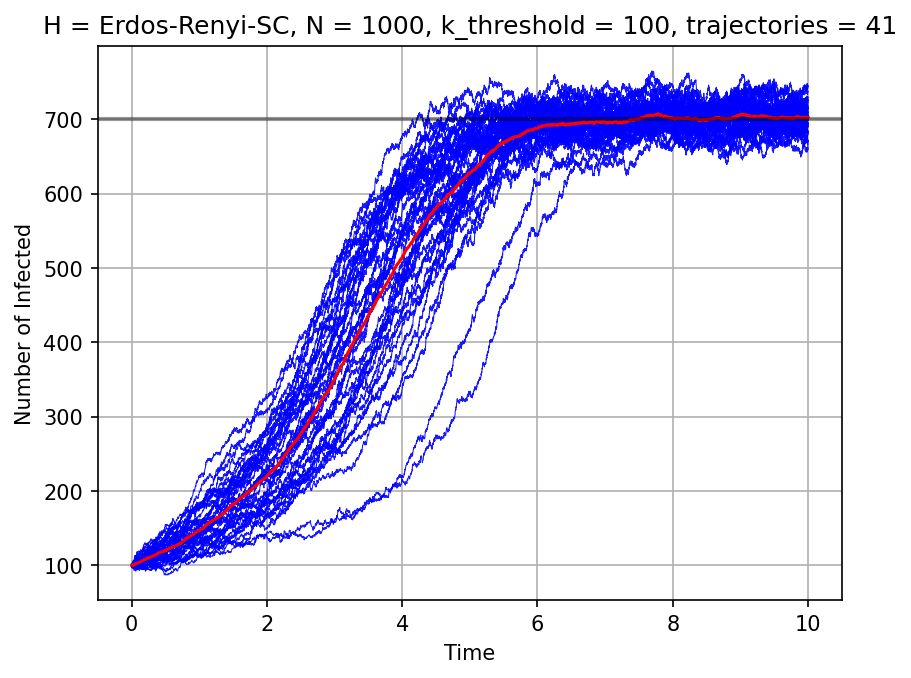

In [9]:
# plot X_t curves in gray and average curve in red
fig = plt.figure(dpi=150) # set DPI
ax  = plt.subplot()

for X_t in X_sims_aligned:
    ax.plot(X_t[0], X_t[2], c="blue", alpha=0.9, linewidth=0.5, rasterized=True)

avg_curve, times = get_average(X_sims_aligned, new_time_max, len(X_sims_aligned), delta_t = 0.01)

plt.plot(times, avg_curve, "red")

plt.axhline(y=int(0.7 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, k_threshold = {k_threshold}, trajectories = {len(X_sims_aligned)}")
plt.savefig(f"../figures/estimation/{test_name}/gillespie-sims-aligned.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()
plt.close(fig) # free up memory

In [7]:
times

array([ 0.  ,  0.01,  0.02, ...,  9.98,  9.99, 10.  ], shape=(1001,))

## Solve KEs and compare

In [11]:
target_p1 = d1 / (N - 1.0)
target_p2 = (2.0 * d2) / ((N - 1.0) * (N - 2.0))

I0 = 100

# solve KEs and compare
all_states = list(range(N + 1))
M = len(all_states)
# ode_system_complete = list_all_ODEs_complete(g, beta1, beta2, mu)
ode_system_random = list_all_ODEs_random(g, beta1, beta2, mu, target_p1, target_p2)

# set the initial condition
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0
# p0

In [12]:
# solve ode_system_random over time
t_span = (0.0, new_time_max)

# times t_i to evaluate in, get saved in sol.t
steps_eval = 202
t_eval = np.linspace(t_span[0], t_span[1], steps_eval)

def f_ode(t, p):
    return ode_system_random(t, p)

sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="LSODA")

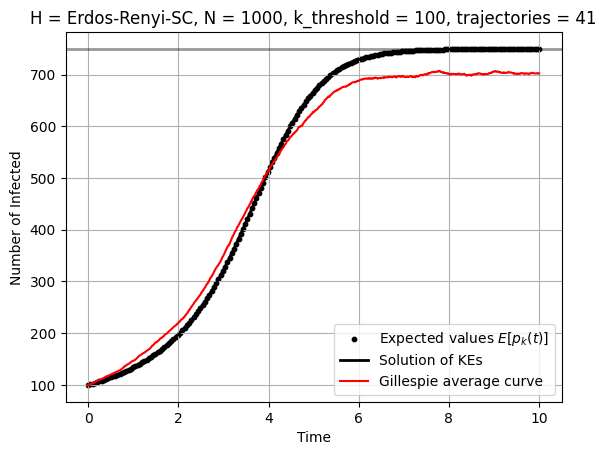

In [13]:
# plot both the expected values of p_{k}(t) 
# and the Gillespie average curve
# on the same figure

expected_values = calculate_expected_values(sol)

plt.figure()
plt.scatter(sol.t, expected_values, s = 10, color="k", 
            label=r"Expected values $E[p_{k}(t)]$")
plt.plot(sol.t, expected_values, lw=2, color="k", label="Solution of KEs")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve")

plt.axhline(y=int(0.75 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, k_threshold = {k_threshold}, trajectories = {len(X_sims_aligned)}")
plt.savefig(f"../figures/estimation/{test_name}/solution-vs-gillepsie.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

## Calculate the estimates

In [14]:
## --- Calculate the estimates ---
min_Tk_threshold = 1e-6
estimates = calculate_estimates(X_sims_aligned, N, min_Tk_threshold)

Total events processed: 440040


In [18]:
estimates

{'a_k_hat': array([0., 0., 0., ..., 0., 0., 0.], shape=(1001,)),
 'b_k_hat': array([0., 0., 0., ..., 0., 0., 0.], shape=(1001,)),
 'c_k_hat': array([0., 0., 0., ..., 0., 0., 0.], shape=(1001,)),
 'T_k': array([0., 0., 0., ..., 0., 0., 0.], shape=(1001,)),
 'U_k': array([0., 0., 0., ..., 0., 0., 0.], shape=(1001,)),
 'V_k': array([0., 0., 0., ..., 0., 0., 0.], shape=(1001,)),
 'D_k': array([0., 0., 0., ..., 0., 0., 0.], shape=(1001,))}

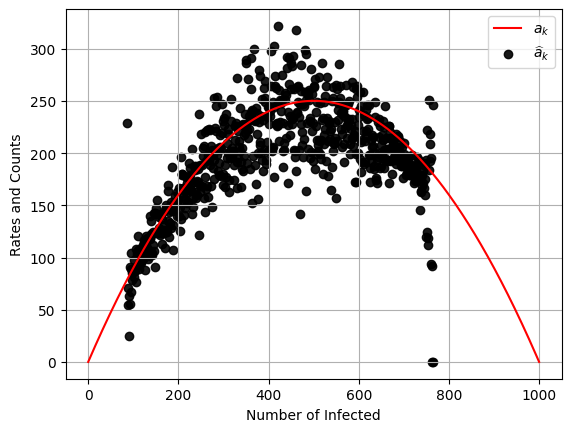

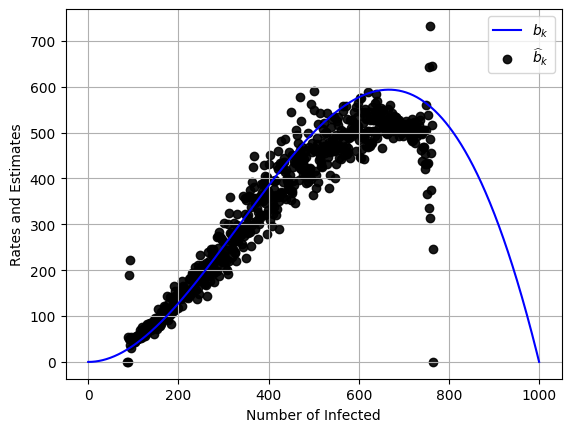

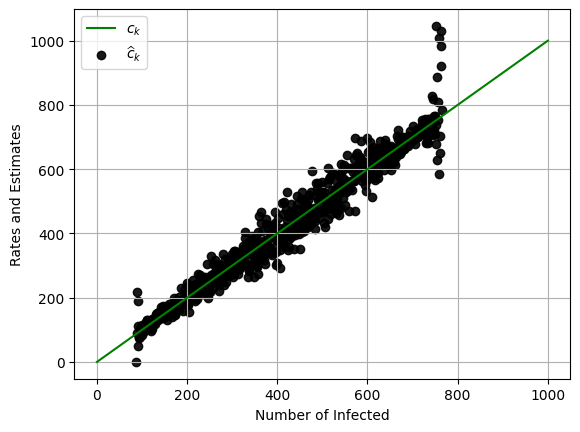

In [15]:
a_k_hat = estimates["a_k_hat"]
b_k_hat = estimates["b_k_hat"]
c_k_hat = estimates["c_k_hat"]

# plot only where T_k was non-zero!
valid_k_idx = estimates["T_k"] > min_Tk_threshold   

# and compare them to theoretical rates
k_values = np.arange(0, N + 1) # number of infected from 0 to N
k_choose_2 = np.array(list(map(lambda k: comb(k, 2, exact=True), k_values)))

# TODO: what are theoretical rates now?
a_k = target_p1 * beta1 * k_values * (N - k_values)
b_k = target_p2 * beta2 * k_choose_2 * (N - k_values)

# TODO: replace c_k with sum lambda_k = birth_rate_k = a_k + b_k
c_k = mu * k_values

fig = plt.figure()
ax = plt.subplot()

# theoretical ak vs. ak hats 
ax.plot(k_values, a_k, label=r'$a_k$', color="red")
ax.scatter(k_values[valid_k_idx], a_k_hat[valid_k_idx],
        label=r'$\widehat{a}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Counts")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/{test_name}/estimates_ak.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

# theoretical bk vs. bk hats
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, b_k, label=r'$b_k$', color="blue")
ax.scatter(k_values[valid_k_idx], b_k_hat[valid_k_idx],
        label=r'$\widehat{b}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)    
plt.savefig(f"../figures/estimation/{test_name}/estimates_bk.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

# theoretical ck vs. ck hats (as a test only)
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, c_k, label=r'$c_k$', color="green")
ax.scatter(k_values[valid_k_idx], c_k_hat[valid_k_idx],
        label=r'$\widehat{c}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)
plt.savefig(f"../figures/estimation/{test_name}/estimates_ck.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

## Solve KEs using the estimates

In [16]:
## --- Solve KEs using the estimates and compare ---
# --- Model 2 ---
ode_system_complete = list_all_ODEs_using_estimates(g, a_k_hat, b_k_hat, mu)

def f_ode(t, p):
    return ode_system_complete(t, p)


all_states = list(range(N + 1))
M = len(all_states)
I0 = 100
p0 = np.zeros(M)
i_set0 = all_states.index(I0)
p0[i_set0] = 1.0 # all other states have prob 0 at time 0

sol_hat = solve_ivp(f_ode, 
                    t_span, 
                    p0, 
                    t_eval=t_eval,
                    method="LSODA")

expected_values_hat = calculate_expected_values(sol_hat)

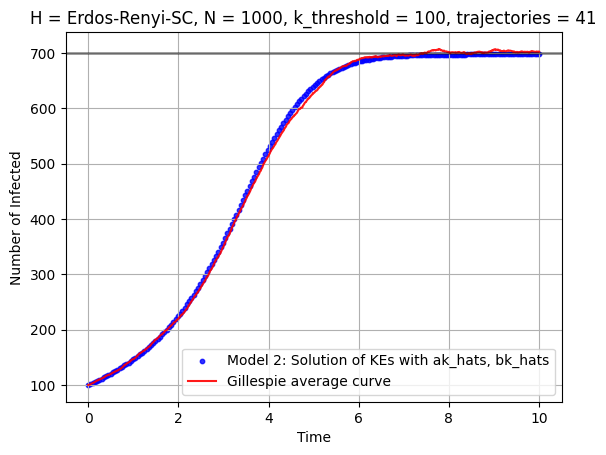

In [17]:
plt.figure()

# plt.plot(sol.t, expected_values_hat, color="b", label="Model 2: Solution of KEs with ak_hats, bk_hats")
plt.scatter(sol.t, expected_values_hat, color="b", s=10, alpha=.8, label="Model 2: Solution of KEs with ak_hats, bk_hats")

plt.plot(times, avg_curve, 'red', label="Gillespie average curve", alpha=0.9)

plt.axhline(y=int(0.7 * N), color='black', lw=2, alpha=0.4, linestyle='-')

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.title(f"H = {g.name}, N = {N}, k_threshold = {k_threshold}, trajectories = {len(X_sims_aligned)}")
plt.savefig(f"../figures/estimation/{test_name}/solutions-comparison.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()